In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DecimalType, FloatType
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [2]:
# create sparksession
spark = SparkSession.builder.appName("COVID").config("spark.some.config.option", "some-value").getOrCreate()
confirmed = spark.read.csv('time_series_19-covid-Confirmed_archived_0325.csv', header=True, inferSchema = True)
# I will start by creating temporary tables querying with SQL
confirmed.createOrReplaceTempView('COVID_Confirmed')
sparkConfirmedDF = spark.sql('''SELECT * FROM COVID_Confirmed''')

In [3]:
# Handling (Dropping) 'NULL / None' Values
ConfirmedDF = sparkConfirmedDF.na.drop()
# Selecting Australia Confirmed Cases
confirmed = spark.sql(
'''
SELECT * FROM COVID_Confirmed 
WHERE `Country/Region` = 'Australia'
'''
)
confirmed.show()

+--------------------+--------------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Province/State|Country/Region|     Lat|    Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|1/29/20|1/30/20|1/31/20|2/1/20|2/2/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|3/1/20|3/2/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|3/10/20|3/11/20|3/12/20|3/13/20|3/14/20|3/15/

In [4]:
columns_to_select = confirmed.columns[14:]
# Selecting a subset from the dataframe
confirmed = confirmed.select(columns_to_select)
# sum up all rows data into 1 row (merging)
confirmed = confirmed.select(confirmed.columns).groupBy().sum()
# renaming column names for indexing
counter = 0

for column in confirmed.columns:
    confirmed = confirmed.withColumnRenamed(f"{column}", f"{counter}")
    counter = counter + 1

confirmed.toPandas()
# transpose the dataframe
confirmed_transpose = confirmed.toPandas().transpose()
# Create a Spark DataFrame from our Pandas DataFrame
confirmed_transpose = confirmed_transpose.reset_index()
confirmedSparkDF = spark.createDataFrame(confirmed_transpose)
confirmedSparkDF = confirmedSparkDF.withColumn("indexes", confirmedSparkDF['index'].cast(DecimalType()))
confirmedSparkDF.show(5)

+-----+---+-------+
|index|  0|indexes|
+-----+---+-------+
|    0| 12|      0|
|    1| 12|      1|
|    2| 12|      2|
|    3| 13|      3|
|    4| 13|      4|
+-----+---+-------+
only showing top 5 rows



In [5]:
featureassembler = VectorAssembler(inputCols = ['indexes'], outputCol="Features")
output = featureassembler.transform(confirmedSparkDF)
finalized_data = output.select("Features", "0")
finalized_data.show(5)

+--------+---+
|Features|  0|
+--------+---+
|   [0.0]| 12|
|   [1.0]| 12|
|   [2.0]| 12|
|   [3.0]| 13|
|   [4.0]| 13|
+--------+---+
only showing top 5 rows



In [6]:
finalized_data = finalized_data.toPandas()
train_data = finalized_data[ : -2]
test_data = finalized_data[-2 : ]
train_data_DF = spark.createDataFrame(train_data)
train_data_DF.show(5)
test_data_DF = spark.createDataFrame(test_data)
test_data_DF.show()

+--------+---+
|Features|  0|
+--------+---+
|   [0.0]| 12|
|   [1.0]| 12|
|   [2.0]| 12|
|   [3.0]| 13|
|   [4.0]| 13|
+--------+---+
only showing top 5 rows

+--------+----+
|Features|   0|
+--------+----+
|  [50.0]|1314|
|  [51.0]|1314|
+--------+----+



In [7]:
regressor = LinearRegression(featuresCol='Features', labelCol='0', maxIter=10, regParam=0.8, elasticNetParam=0.5)
regressor = regressor.fit(train_data_DF)
regressor.coefficients,regressor.intercept

(DenseVector([10.3084]), -131.9753565268633)

In [8]:
Summary = regressor.summary
print("total Iterations: %d" % Summary.totalIterations)
print("RMSE: %f" % Summary.rootMeanSquaredError)
print("R-squared: %f" % Summary.r2)
train_data_DF.describe().show()

total Iterations: 3
RMSE: 163.472712
R-squared: 0.455198
+-------+------------------+
|summary|                 0|
+-------+------------------+
|  count|                50|
|   mean|            120.58|
| stddev|223.72423714411073|
|    min|                12|
|    max|              1071|
+-------+------------------+



In [9]:
pred_results = regressor.evaluate(test_data_DF)
pred_results.predictions.show()

+--------+----+-----------------+
|Features|   0|       prediction|
+--------+----+-----------------+
|  [50.0]|1314|383.4437384259189|
|  [51.0]|1314|393.7521203249746|
+--------+----+-----------------+



In [10]:
# calculating difference
predictedDF = pred_results.predictions
predictedPD = predictedDF.toPandas().reset_index()
predictedPD = predictedPD[['index', 'prediction']]

prediction = pred_results.predictions.select("prediction").collect()

test_result = spark.createDataFrame(test_data[['0']])
test_result = test_result.withColumnRenamed("0","actual")

test_result = test_result.select("actual").collect()

actualDF = spark.createDataFrame(test_result)
actualPD = actualDF.toPandas().reset_index()

actual_cases = []
predicted_cases = []
for actual in test_result:
    actual_cases.append(float(actual.actual))
    
for predicts in prediction:
    predicted_cases.append(predicts.prediction)
    
difference = [actual - predicted for actual, predicted in zip(actual_cases, predicted_cases)]

differenceDF = spark.createDataFrame(difference, FloatType())
differenceDF = differenceDF.withColumnRenamed("value","difference")
differencePD = differenceDF.toPandas().reset_index()
differencePD

,index,difference
0,0,930.556274
1,1,920.247864


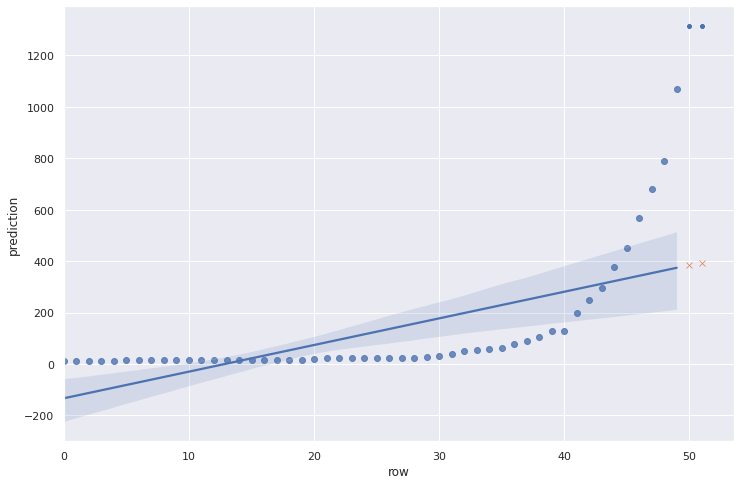

In [11]:
# create regression plot
finalized_data=finalized_data.reset_index().drop(columns={'Features'})
x=predictedDF.toPandas()
x['row']=[50,51]
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='index',y='0',data=finalized_data[ : -2])
sns.scatterplot(x='row',y='0',data=x)
sns.scatterplot(x='row',y='prediction',data=x,marker='x')

In [ ]:
#End